## Installation der benötigten Bibliotheken

Damit alle Funktionen dieses Notebooks korrekt ausgeführt werden können, müssen zunächst die
benötigten Python-Bibliotheken installiert werden.  
Führe dazu die folgende Zelle aus:

In [1]:
%pip install pandas numpy matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Berechnung von wichtigen Koeefizienten aus historischen Daten

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import os

base_dir = os.getcwd()   # gibt das aktuelle Arbeitsverzeichnis zurück

# --- Datei-Pfade ---
data_pfad = os.path.join(base_dir, "data") # Pfad zum Ordner "data"
temperature_history_path = os.path.join(data_pfad, "temperature_history.xlsx") # Fertiger Pfad zur Excel-Datei
temperature_norm_path = os.path.join(data_pfad, "temperature_norm.xlsx") # Fertiger Pfad zur Excel-Datei

# --- historische Temperaturdaten laden und vorbereiten ---
temperature_history_excel = pd.read_excel(temperature_history_path) # Excel-Datei laden
temperature_history_excel['date'] = temperature_history_excel['date'] = pd.to_datetime(temperature_history_excel['date']) # Spalte "date" ins Datumsformat bringen
temperature_history_excel['month'] = temperature_history_excel['date'].dt.month

# --- Temperaturspalten bereinigen ---
# Kommas werden durch Punkte ersetzt (damit die Werte als echte float-Werte interpretiert werden)
temperature_history_excel['tavg'] = temperature_history_excel['tavg'].astype(str).str.replace(',', '.').astype(float)
temperature_history_excel['tmin'] = temperature_history_excel['tmin'].astype(str).str.replace(',', '.').astype(float)
temperature_history_excel['tmax'] = temperature_history_excel['tmax'].astype(str).str.replace(',', '.').astype(float)

# --- Umwandlung in NumPy-Arrays ---
tavg_array = temperature_history_excel['tavg'].to_numpy()
tmin_array = temperature_history_excel['tmin'].to_numpy()
tmax_array = temperature_history_excel['tmax'].to_numpy()

# --- Globale Extremwerte ---
tmin_global = np.min(tmin_array)
tmax_global = np.max(tmax_array)

# --- Monatliche Varianz ---
monthly_var = temperature_history_excel.groupby('month')['tavg'].var().to_numpy()

# --- Monatliche min/max-Grenzen als Dictionary ---
monatsgrenzen = temperature_history_excel.groupby('month')['tavg'].agg(['min', 'max']).round(1).to_dict(orient='index')

# --- Autokorrelationen berechnen ---
temperature_history_excel['tavg_lag1'] = temperature_history_excel['tavg'].shift(1)
temperature_history_excel['tavg_lag2'] = temperature_history_excel['tavg'].shift(2)
temperature_history_excel['tavg_lag3'] = temperature_history_excel['tavg'].shift(3)
temperature_history_excel['tavg_lag4'] = temperature_history_excel['tavg'].shift(4)

autokorrelationen = {
    1: round(temperature_history_excel[['tavg', 'tavg_lag1']].corr().iloc[0, 1], 4),
    2: round(temperature_history_excel[['tavg', 'tavg_lag2']].corr().iloc[0, 1], 4),
    3: round(temperature_history_excel[['tavg', 'tavg_lag3']].corr().iloc[0, 1], 4),
    4: round(temperature_history_excel[['tavg', 'tavg_lag4']].corr().iloc[0, 1], 4)
}

print('✓ ferig')

✓ ferig


## Norm-Temperatur importieren und visualisieren

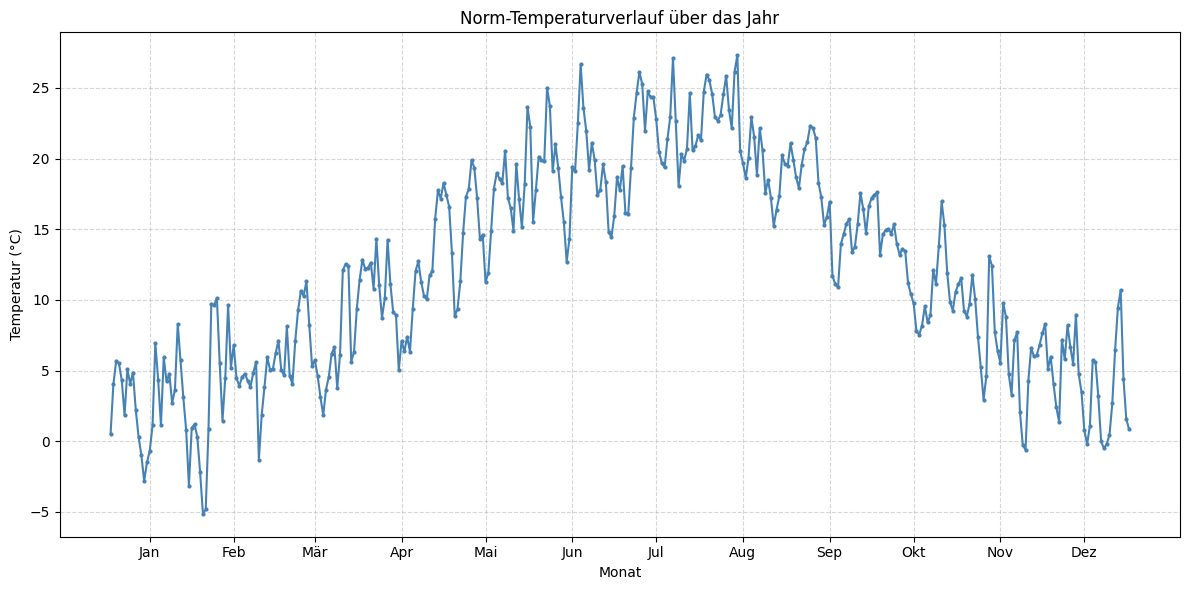

In [3]:
import matplotlib.pyplot as plt

# --- Referenzjahr (Normtemperatur) laden ---
temperature_norm_excel = pd.read_excel(temperature_norm_path)
temperature_norm_excel['Temperatur'] = temperature_norm_excel['Temperatur'].astype(str).str.replace(',', '.').astype(float)
temperature_norm_excel['TagID'] = temperature_norm_excel['Monat'].astype(str).str.zfill(2) + '-' + temperature_norm_excel['Tag'].astype(str).str.zfill(2)
daily_avg = temperature_norm_excel.groupby('TagID')['Temperatur'].mean()

if len(daily_avg) != 365:
    raise ValueError("Der Referenzdatensatz enthält nicht genau 365 Tage!")

norm_temperatur = daily_avg.to_numpy() # Norm-Temperatur in Array spreichern

# --- Datumsarray für ein Normjahr ---
start_datum = datetime(2025, 1, 1)
datumsliste_referenzjahr_str = [(start_datum + timedelta(days=i)).strftime("%Y-%m-%d") for i in range(365)]
datumsliste_referenzjahr_dt = [start_datum + timedelta(days=i) for i in range(365)]

# Normalwerte verwenden (aus Speicher)
y = norm_temperatur
x = np.arange(1, 366)

# Monatsgrenzen und Namen
tage_pro_monat = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
grenze = np.cumsum([0] + tage_pro_monat)
monatsnamen = ['Jan', 'Feb', 'Mär', 'Apr', 'Mai', 'Jun',
               'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dez']

# Plot
plt.figure(figsize=(12, 6))
plt.plot(x, y, marker='o', linestyle='-', color='steelblue', markersize=2, linewidth=1.5)
plt.title("Norm-Temperaturverlauf über das Jahr")
plt.xlabel("Monat")
plt.ylabel("Temperatur (°C)")

# Monatsnamen als X-Achsen-Beschriftung
plt.xticks([(grenze[i] + grenze[i+1]) // 2 for i in range(12)], monatsnamen)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Temperatur Szenarien erstellen

In [4]:
# -------- Eingabeparameter für die Simulation -----------------------------

simulation_start_datum = date(2025, 7, 15) # Ab diesem Tag [t] (inkl.) wird die Temperatur prognosiert 
letzte_4_tage = [21.0, 22.0, 23.0, 24.0]  #  # Hier die Temperaturen von letzten 4 Tagen eingeben [t-1, t-2, t-3, t-4]
                                         # wie z.B. [4.0, 3.0, 2.0, 1.0]
simulationsdauer = 365 # Anzahl der Tage, für die Temperaturverläufe simuliert werden sollen
simulation_anzahl = 100 # Anzahl der unabhängigen Temperaturszenarien (Forecasts), die erzeugt werden

# -------------------------------------------------------------------------

# Seed setzen für Reproduzierbarkeit
np.random.seed(42)

def tempszenarien_generieren(simulation_start_datum, letzte_4_tage, simulationsdauer, simulation_anzahl,
                        monthly_var=None,
                        norm_temperatur=None,
                        autokorrelationen=None,
                        monatsgrenzen=None):

    # Autokorrelationen normalisieren (Summe = 1)
    summe = sum(autokorrelationen.values())
    autokorrelationen_norm = {lag: wert / summe for lag, wert in autokorrelationen.items()}

    # Startindex im Jahr berechnen
    start_tag_im_jahr = (simulation_start_datum - date(simulation_start_datum.year, 1, 1)).days

    # Liste der simulierten Daten
    datums_liste = [
        (simulation_start_datum + timedelta(days=i)).isoformat()
        for i in range(simulationsdauer)
    ]

    # Liste für alle Temperaturszenarien
    alle_szenarien = []

    # Schleife über Anzahl der Szenarien
    for i in range(simulation_anzahl):

        delta_hist = [] # hier werden die Abweichungen von Norm-Temperatur gespeichert.

        # Die Differenzen für die letzten bekannten 4 Tagen vorbereiten
        for j in range(4):
            tag_datum = simulation_start_datum - timedelta(days=j + 1)
            temp = letzte_4_tage[j]  # j = 0 → t-1, j = 3 → t-4
            tag_index = (tag_datum - date(tag_datum.year, 1, 1)).days
            klimawert = norm_temperatur[tag_index]
            delta = temp - klimawert
            delta_hist.append(delta)

        resultat = []
        for tag in range(simulationsdauer):
            aktuelles_datum = simulation_start_datum + timedelta(days=tag)
            monat = aktuelles_datum.month
            tag_index = (aktuelles_datum - date(aktuelles_datum.year, 1, 1)).days
            normal_temp = norm_temperatur[tag_index]

            # AR(4)-Berechnung manuell und transparent
            autoreg_delta = 0.0
            for lag in range(1, 5):
                gewicht = autokorrelationen_norm.get(lag, 0.0)
                vergangenes_delta = delta_hist[-lag]
                produkt = gewicht * vergangenes_delta
                autoreg_delta += produkt

            # Rauschen hinzufügen
            std_abw = np.sqrt(monthly_var[monat - 1]) # Standardabweichung aus monatlichen Varianz berechnen
            noise = np.random.normal(0, std_abw) # Zufallswert mit dem Erwartungswert 0 und Standardabweichung
            delta_neu = max(-15, min(15, autoreg_delta + noise)) # Sicherheitsbremse, damit keine extreme Temperaturschwankungen rauskommen

            # Neue Temperatur berechnen und speichern
            neue_temp = normal_temp + delta_neu

            # Monatsgrenzen anwenden (um Extremwerte zu dämpfen)
            grenzen = monatsgrenzen[monat]
            grenz_min = grenzen["min"]
            grenz_max = grenzen["max"]

            if neue_temp < grenz_min:
                neue_temp = 0.8 * neue_temp + 0.2 * grenz_min

            elif neue_temp > grenz_max:
                neue_temp = 0.8 * neue_temp + 0.2 * grenz_max

            # Temperatur zum Szenario hinzufügen
            resultat.append(round(neue_temp, 2)) 

            # delta_hist aktualisieren und kürzen
            delta_hist.append(delta_neu)
            if len(delta_hist) > 4:
                delta_hist = delta_hist[-4:]

        # Szenario zum Gesamtergebnis hinzufügen
        alle_szenarien.append(resultat)

    return alle_szenarien, datums_liste

alle_szenarien, datumsliste = tempszenarien_generieren(
    simulation_start_datum=simulation_start_datum,
    letzte_4_tage=letzte_4_tage,
    simulationsdauer=simulationsdauer,
    simulation_anzahl=simulation_anzahl,
    monthly_var=monthly_var,
    norm_temperatur=norm_temperatur,
    autokorrelationen=autokorrelationen,
    monatsgrenzen=monatsgrenzen)

print(f"✓ {len(alle_szenarien)} Temperaturszenarien mit jeweils {len(alle_szenarien[0])} Tagen wurden erfolgreich erzeugt.")


✓ 100 Temperaturszenarien mit jeweils 365 Tagen wurden erfolgreich erzeugt.


## Visualisierung stochastischer Temperaturszenarien


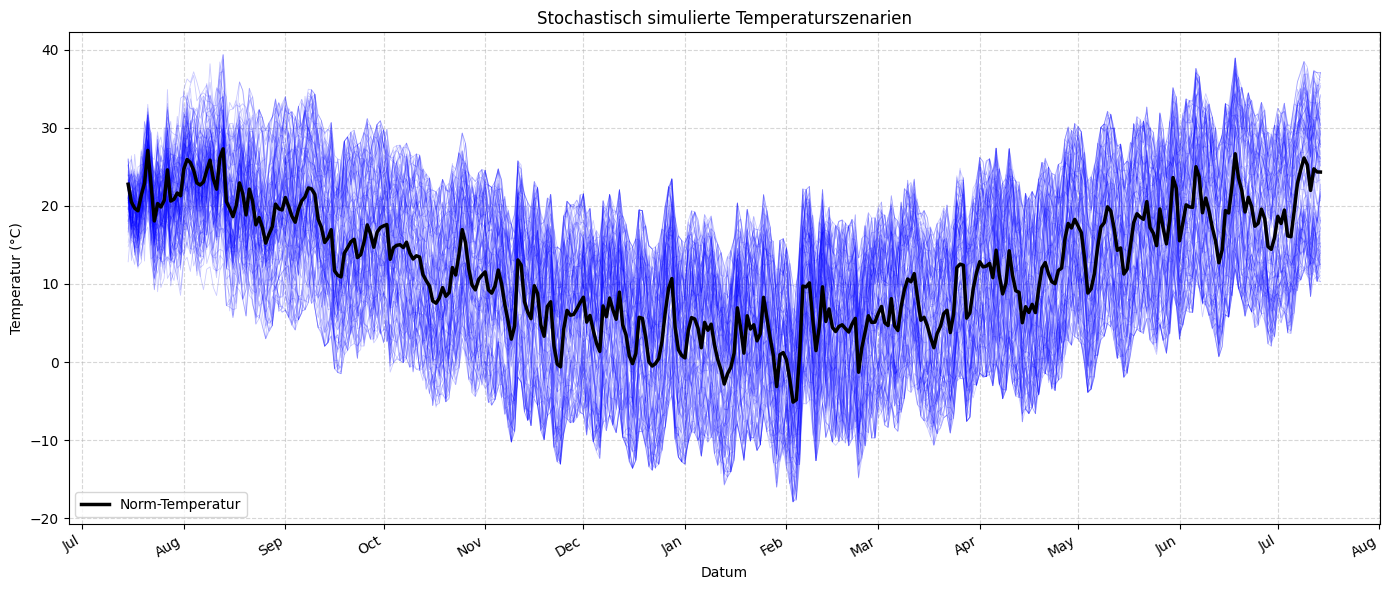

In [5]:
import matplotlib.dates as mdates

# Neue Liste mit echten datetime.date-Objekten (nur für Visualisierung)
datumsliste_dt = [datetime.strptime(d, "%Y-%m-%d").date() if isinstance(d, str) else d for d in datumsliste]

# Klimakurve passend zur Visualisierung
start_tag = (datumsliste_dt[0] - date(datumsliste_dt[0].year, 1, 1)).days
norm_temperatur_kurve = [norm_temperatur[(start_tag + i) % 365] for i in range(len(datumsliste_dt))]

# Plot vorbereiten
plt.figure(figsize=(14, 6))

# Szenarien plotten
for szenario in alle_szenarien:
    plt.plot(datumsliste_dt, szenario, linewidth=0.6, alpha=0.2, color='blue')

# Norm-Temperatur hinzufügen
plt.plot(datumsliste_dt, norm_temperatur_kurve, color='black', linewidth=2.5, label="Norm-Temperatur")

# Formatierungen
plt.title("Stochastisch simulierte Temperaturszenarien")
plt.xlabel("Datum")
plt.ylabel("Temperatur (°C)")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.gcf().autofmt_xdate()
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## Funktion zur Berechnung der Allokationsmenge

In [6]:
# --- Globale Parameter definieren ---

KW = 50  # Kundenwert in kWh angeben

# Funktionsparameter (von ANB für den Profil gegeben)
# Sigmoid-Parameter
A = 1.3819663
B = -37.4124155
C = 6.1723179
D = 0.0396284
theta_0 = 40  # ϑ₀

# Linear-Parameter
m_H = -0.0672159
b_H = 1.1167138
m_W = -0.0019982
b_W = 0.1355070

# Wochentagsfaktoren (Montag bis Sonntag)
wochentagsfaktoren = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


# --- Funktion 1: Profilfunktion (f_sig + f_lin) ---
def profilfunktion(temp):
    temp = round(temp, 2)
    delta = 1e-2
    diff = temp - theta_0

    # Teilen durch 0 vermeiden
    if abs(diff) < delta:
        diff = delta
        temp = theta_0 + delta

    # Teilen durch 0 vermeiden
    divisor = 1 + (B / diff) ** C
    if abs(divisor) < delta:
        divisor += delta

    # Sigmoid Teil berechnen
    f_sig = A / divisor + D

    # Linearen Teil berechnen
    f_lin = max(m_H * temp + b_H, m_W * temp + b_W)

    return round(f_sig + f_lin, 5)


# --- Funktion 2: Tagesverbrauch mit Wochentag ---
def berechne_q_tag(temp, datum_str):
    datum = datetime.strptime(datum_str, "%Y-%m-%d").date() if isinstance(datum_str, str) else datum_str
    wochentag = datum.weekday()
    F_WT = wochentagsfaktoren[wochentag]
    return round(KW * profilfunktion(temp) * F_WT, 2)


# --- Funktion 3: Verbrauch für ganze Periode ---
# Berechnet den täglichen Verbrauch für eine gegebene Temperaturreihe und Datumsreihe
def verbrauch_berechnen(temp_liste, datums_liste):
    
    verbrauch = []

    for i in range(len(temp_liste)):
        T_D = temp_liste[i]

        if i < 3: # für die ersten 4 Tagen der Simulation hat Modell noch keine Werte zur Berechnung der Allokationstemperatur
            T_input = T_D
        else:
            T_D1 = temp_liste[i - 1]
            T_D2 = temp_liste[i - 2]
            T_D3 = temp_liste[i - 3]
            T_input = (
                T_D + 0.5 * T_D1 + 0.25 * T_D2 + 0.125 * T_D3
            ) / (1 + 0.5 + 0.25 + 0.125)

        datum = datums_liste[i]
        q_tag = berechne_q_tag(T_input, datum)
        verbrauch.append(q_tag)

    return verbrauch

print('✓ fertig')


✓ fertig


## Berechnung und Visualisierung der Beschaffungsmenge

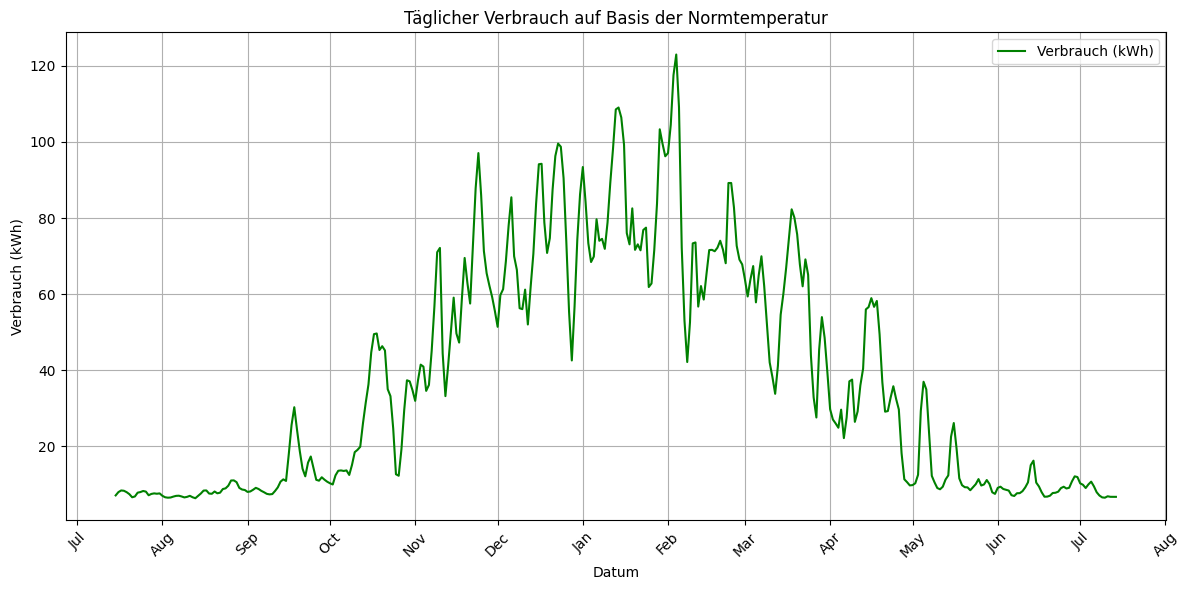

In [7]:
# --- Verbrauch mit Normtemperaturen berechnen (= Beschaffungsmenge) ---
verbrauch_norm = verbrauch_berechnen(norm_temperatur_kurve[:len(datumsliste)], datumsliste)

# Plot erstellen
plt.figure(figsize=(12, 6))
plt.plot(datumsliste_dt, verbrauch_norm, color='green', label='Verbrauch (kWh)')

# Achsentitel und Formatierung
plt.xlabel("Datum")
plt.ylabel("Verbrauch (kWh)")
plt.title("Täglicher Verbrauch auf Basis der Normtemperatur")
plt.grid(True)
plt.legend()

# X-Achse im Monatsformat
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Verbrauchsszenarien auf Basis der simulierten Temperaturen berechnen und visualisieren

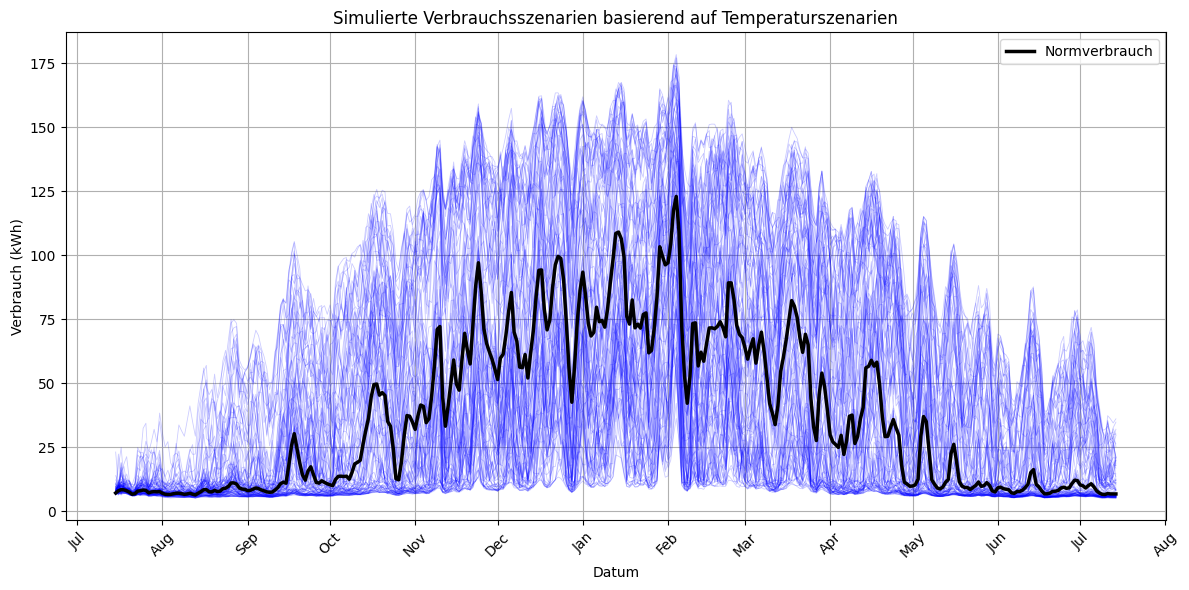

In [8]:
# --- Verbrauch für alle simulierten Szenarien berechnen ---
verbrauch_szenarien = [
    verbrauch_berechnen(szenario, datumsliste)
    for szenario in alle_szenarien
]

# --- Plot erstellen ---
plt.figure(figsize=(12, 6))

# Simulierte Verbrauchskurven plotten (grau, transparent)
for v in verbrauch_szenarien:
    plt.plot(datumsliste_dt, v, linewidth=0.6, alpha=0.2, color='blue')

# Normale Verbrauchskurve hinzufügen (grün)
plt.plot(datumsliste_dt, verbrauch_norm, color='black', linewidth=2.5, label='Normverbrauch')

# Achsen & Beschriftung
plt.xlabel("Datum")
plt.ylabel("Verbrauch (kWh)")
plt.title("Simulierte Verbrauchsszenarien basierend auf Temperaturszenarien")
plt.grid(True)
plt.legend()

# X-Achse als Monatsformat
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Differenzszenarien für die Beschaffungsbewertung


In [9]:
# --- Differenzszenarien berechnen zwischen Beschaffung und allen Verbrauchsszenarien --- 

differenz_szenarien = []

for szenario in verbrauch_szenarien:
    if len(szenario) != len(verbrauch_norm):
        raise ValueError("❌ Ein Szenario hat nicht die gleiche Länge wie die Grundlage.")

    differenz = [round(vn - vs, 3) for vn, vs in zip(verbrauch_norm, szenario)]
    differenz_szenarien.append(differenz)

print(f"✓ {len(differenz_szenarien)} Differenzszenarien erfolgreich berechnet.")

✓ 100 Differenzszenarien erfolgreich berechnet.


## Spot Preis Simulation

**Wichtige Variablen für die Preis-Simulation aus historischen Daten und aktuellen Spot- & Terminpreisen bestimmen**


In [10]:
# --- Datei-Pfade ---
terminpreise_historisch_path = os.path.join(data_pfad, "terminpreise_historisch.xlsx") # Fertiger Pfad zur Excel-Datei
spot_preise_historisch_path = os.path.join(data_pfad, "spot_preise_historisch.xlsx") # Fertiger Pfad zur Excel-Datei
terminpreise_aktuell_path = os.path.join(data_pfad, "terminpreise_aktuell.xlsx")

# --- historische Temperaturdaten laden und vorbereiten ---
terminpreise_historisch_excel = pd.read_excel(terminpreise_historisch_path)
spot_preise_historisch_excel = pd.read_excel(spot_preise_historisch_path)
terminpreise_aktuell_excel = pd.read_excel(terminpreise_aktuell_path)

# Datumsformat korrigieren und Preise als float (Komma → Punkt)
terminpreise_historisch_excel['delivery_begin'] = pd.to_datetime(terminpreise_historisch_excel['delivery_begin'], dayfirst=True)
terminpreise_historisch_excel['price'] = terminpreise_historisch_excel['price'].astype(str).str.replace(",", ".").astype(float)

spot_preise_historisch_excel['date'] = pd.to_datetime(spot_preise_historisch_excel['date'])
spot_preise_historisch_excel['price'] = spot_preise_historisch_excel['price'].astype(str).str.replace(",", ".").astype(float)

terminpreise_aktuell_excel['delivery_begin'] = pd.to_datetime(terminpreise_aktuell_excel['delivery_begin'], dayfirst=True)
terminpreise_aktuell_excel['price'] = terminpreise_aktuell_excel['price'].astype(str).str.replace(",", ".").astype(float)

# Nur Terminpreise ab 2024 behalten
terminpreise_historisch_excel = terminpreise_historisch_excel[
    (terminpreise_historisch_excel['delivery_begin'].dt.year >= 2024) 
].reset_index(drop=True)

# Nur Spotpreise ab 2024 behalten
spot_preise_historisch_excel = spot_preise_historisch_excel[
    (spot_preise_historisch_excel['date'].dt.year >= 2024)
].reset_index(drop=True)

# --- Dictionary erstellen: {datetime(YYYY, MM, 1): Preis} ---
aktuelle_terminpreise_dict = dict(zip(
    terminpreise_aktuell_excel['delivery_begin'],
    terminpreise_aktuell_excel['price']
))

print("✓ aktuelle Terminpreise geladen:")
print("✓ historische Terminpreise geladen und gefiltert")
print("✓ historische Spotpreise geladen und gefiltert")

# --- Statistische Kennzahlen Spotpreise: Min, Max und Standardabweichung berechnen ---
spot_min = spot_preise_historisch_excel['price'].min()
spot_max = spot_preise_historisch_excel['price'].max()
spot_std = spot_preise_historisch_excel['price'].std()
spot_std_daily = spot_preise_historisch_excel['price'].diff().std()


# --- AR(1) Korrelation berechnen ---
spot_preise_historisch_excel['price_lag1'] = spot_preise_historisch_excel['price'].shift(1)
autokorrelation_preis_lag1 = spot_preise_historisch_excel[['price', 'price_lag1']].corr().iloc[0, 1]

# Spotpreise → Monatsdurchschnitt berechnen
spot_preise_historisch_excel['monat'] = spot_preise_historisch_excel['date'].dt.to_period('M')
spot_monatsmittel = spot_preise_historisch_excel.groupby('monat')['price'].mean().reset_index()
spot_monatsmittel['monat'] = spot_monatsmittel['monat'].dt.to_timestamp()

# Terminpreise ebenfalls auf Monatsbeginn setzen
terminpreise_historisch_excel['monat'] = terminpreise_historisch_excel['delivery_begin'].dt.to_period('M')
terminpreise_historisch_excel['monat'] = terminpreise_historisch_excel['monat'].dt.to_timestamp()

# Merge Spot- und Terminpreise über Monat
vergleich_df = pd.merge(spot_monatsmittel, terminpreise_historisch_excel, on='monat', suffixes=('_spot', '_termin'))

# Relative Abweichung berechnen (in %)
vergleich_df['abweichung_prozent'] = ((vergleich_df['price_spot'] - vergleich_df['price_termin']) / vergleich_df['price_termin']) * 100

# Statistische Kennzahlen der Abweichung
abweichung_min = vergleich_df['abweichung_prozent'].min()
abweichung_max = vergleich_df['abweichung_prozent'].max()
abweichung_std = vergleich_df['abweichung_prozent'].std()



✓ aktuelle Terminpreise geladen:
✓ historische Terminpreise geladen und gefiltert
✓ historische Spotpreise geladen und gefiltert


## Interpollierte Terminverlauf

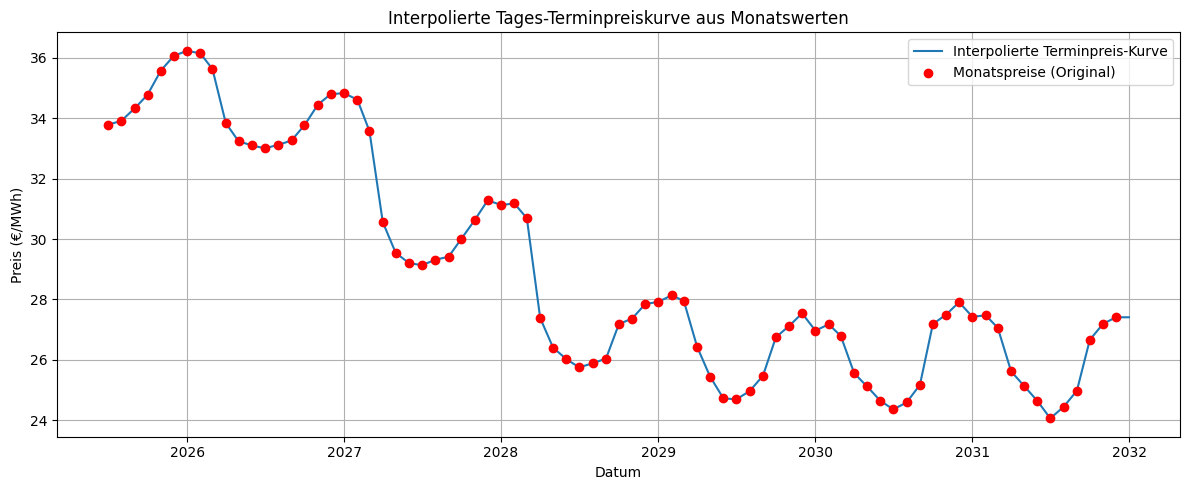

In [11]:
# 1. Monatsdaten in Serie umwandeln
monatsserie = pd.Series(aktuelle_terminpreise_dict)

# 2. In tägliche Zeitreihe interpolieren
# a) Zeitachse vom ersten bis letzten Monat
start = min(monatsserie.index)
end = max(monatsserie.index) + pd.offsets.MonthEnd(1)
datum_index = pd.date_range(start=start, end=end, freq="D")

# b) Neu als Serie mit täglichem Index
terminpreis_serie = monatsserie.reindex(datum_index, method=None)  # NaNs zwischen Monatsanfängen
terminpreis_serie_interpoliert = terminpreis_serie.interpolate(method='time')  # Zeitbasierte Interpolation

# Plot zur Kontrolle
plt.figure(figsize=(12, 5))
plt.plot(terminpreis_serie_interpoliert, label="Interpolierte Terminpreis-Kurve")
plt.scatter(monatsserie.index, monatsserie.values, color='red', zorder=5, label="Monatspreise (Original)")
plt.title("Interpolierte Tages-Terminpreiskurve aus Monatswerten")
plt.xlabel("Datum")
plt.ylabel("Preis (€/MWh)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Als dict für spätere Verwendung exportieren
täglicher_terminpreis_dict = terminpreis_serie_interpoliert.to_dict()




## Terminpreise generieren


In [12]:
def preisszenarien_generieren(simulation_anzahl, simulationsdauer, datumsliste_dt,
                               täglicher_terminpreis_dict, autokorrelation_preis_lag1,
                               spot_std_daily):
    alle_preisszenarien = []

    for _ in range(simulation_anzahl):
        szenario = []

        for i, aktuelles_datum in enumerate(datumsliste_dt):
            terminpreis = täglicher_terminpreis_dict.get(pd.Timestamp(aktuelles_datum), None)

            if terminpreis is None:
                raise ValueError(f"⚠️ Kein Terminpreis für {aktuelles_datum.strftime('%Y-%m-%d')} gefunden!")

            if i == 0:
                preis_vortag = terminpreis
            else:
                noise = np.random.normal(0, spot_std_daily)
                preis_vortag = terminpreis + (preis_vortag - terminpreis) * autokorrelation_preis_lag1 + noise

            # Preisbegrenzung
            # Weiches Clipping durch Mischung mit dem vorherigen Wert
            if preis_vortag < spot_min:
                preis_vortag = 0.8 * preis_vortag + 0.2 * spot_min
            elif preis_vortag > spot_max:
                preis_vortag = 0.8 * preis_vortag + 0.2 * spot_max


            szenario.append(round(preis_vortag, 3))

        alle_preisszenarien.append(szenario)

    print(f"✓ {simulation_anzahl} Preisszenarien mit je {simulationsdauer} Tagen erzeugt")
    return alle_preisszenarien



alle_preisszenarien = preisszenarien_generieren(
    simulation_anzahl=simulation_anzahl,
    simulationsdauer=simulationsdauer,
    datumsliste_dt=datumsliste_dt,
    täglicher_terminpreis_dict=täglicher_terminpreis_dict,
    autokorrelation_preis_lag1=autokorrelation_preis_lag1,
    spot_std_daily=spot_std_daily
)


✓ 100 Preisszenarien mit je 365 Tagen erzeugt


## Spotpreise plotten

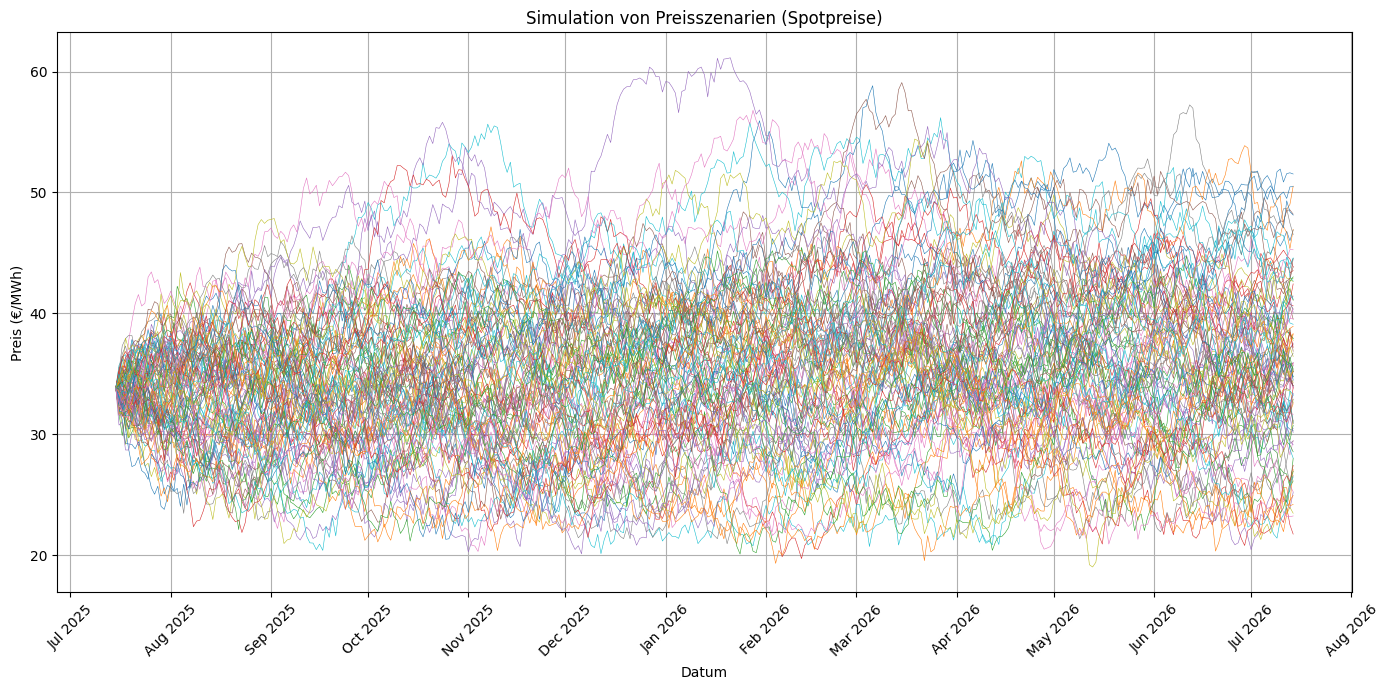

In [13]:
# Datumsliste in datetime umwandeln
datumsliste_dt = [datetime.strptime(d, "%Y-%m-%d") for d in datumsliste]

# Alle Preisszenarien plotten
plt.figure(figsize=(14, 7))
for szenario in alle_preisszenarien:
    plt.plot(datumsliste_dt, szenario, alpha=1, linewidth=0.4)

# Formatierung
plt.xlabel("Datum")
plt.ylabel("Preis (€/MWh)")
plt.title("Simulation von Preisszenarien (Spotpreise)")
plt.grid(True)

# Monatsweise X-Achse
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Beschaffung der prognostizierten Menge (nach Norm-Temperatur) mit Terminpreisen

In [14]:
def berechne_beschaffungskosten(verbrauch_norm, datumsliste_dt, aktueller_terminpreis_dict):

    # Verbrauch mit Datum verknüpfen
    df = pd.DataFrame({
        'datum': datumsliste_dt,
        'verbrauch_kwh': verbrauch_norm
    })

    # Monat extrahieren
    df['monat'] = df['datum'].apply(lambda d: datetime(d.year, d.month, 1))

    # Verbrauch je Monat summieren (kWh → MWh)
    verbrauch_monatlich = df.groupby('monat')['verbrauch_kwh'].sum() / 1000  # → MWh

    # Kosten berechnen
    kosten = 0
    for monat, verbrauch_mwh in verbrauch_monatlich.items():
        preis = aktueller_terminpreis_dict.get(monat)
        if preis is None:
            raise ValueError(f"⚠️ Kein Terminpreis für Monat {monat.strftime('%Y-%m')} gefunden!")
        kosten += verbrauch_mwh * preis

    return round(kosten, 2)

kosten_beschaffung = berechne_beschaffungskosten(
    verbrauch_norm=verbrauch_norm,
    datumsliste_dt=datumsliste_dt,
    aktueller_terminpreis_dict=aktuelle_terminpreise_dict
)

print(f"Gesamtkosten der Beschaffung: {kosten_beschaffung} €")


Gesamtkosten der Beschaffung: 489.74 €


## Monte-Carlo Simulation: Berechnung der Kosten Szenarien. 100 Temperatur Szenarien leifern uns 100 Verbrauchsszenarien. Differnz zwischen Verbrauchsszenario und Beschaffungsszenario wird am Spot-Markt entsprechend an- oder verkauft. Also es ensteht 100x100 Kosten Szenarien, die dann in 100x100 PnL Szenarien umgewandelt werden

In [15]:
def berechne_kostenmatrix_diff(preisszenarien, differenzszenarien):
    anzahl = len(preisszenarien)
    dauer = len(preisszenarien[0])

    kosten_matrix = np.zeros((anzahl, anzahl))  # [i][j] = Verbrauchsszenario i × Preisszenario j

    for i in range(anzahl):
        diff = np.array(differenz_szenarien[i]) / 1000  # kWh → MWh
        for j in range(anzahl):
            preis = np.array(preisszenarien[j])  # €/MWh
            kosten = np.sum(diff * preis)  # → €
            kosten_matrix[i, j] = round(kosten, 2)

    return kosten_matrix

kosten_matrix = berechne_kostenmatrix_diff(
    preisszenarien=alle_preisszenarien,
    differenzszenarien=differenz_szenarien
)

In [16]:
gesamt_kosten = np.sum(kosten_matrix)

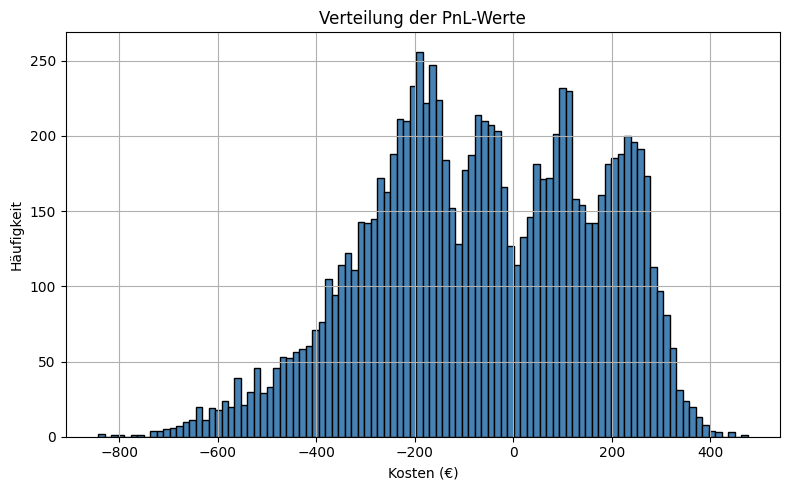

In [17]:
plt.figure(figsize=(8, 5))
plt.hist(kosten_matrix.flatten(), bins=100, color='steelblue', edgecolor='black')
plt.title('Verteilung der PnL-Werte')
plt.xlabel('Kosten (€)')
plt.ylabel('Häufigkeit')
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
# 1. Flatten der Matrix
werte = kosten_matrix.flatten()

# 2. Liste der Konfidenzniveaus
confidence_levels = list(range(5, 100, 5)) + [96, 97, 98, 99]

# 3. Berechnung von VaR und CVaR für jedes Konfidenzniveau
results = []

# Berechne Beschaffungsmenge in MWh (aus np.sum(verbrauch_norm) in kWh)
beschaffungsmenge_mwh = np.sum(verbrauch_norm) / 1000

for conf in confidence_levels:
    alpha = 1 - conf / 100
    var = np.percentile(werte, alpha * 100)
    spezifischer_var = var / beschaffungsmenge_mwh  # €/MWh
    results.append({
        'Konfidenzniveau (%)': conf,
        'VaR (€)': var,
        'VaR (€/MWh)': spezifischer_var
    })

# 4. In DataFrame umwandeln und anzeigen
df = pd.DataFrame(results)
df


,Konfidenzniveau (%),VaR (€),VaR (€/MWh)
0,5,274.3500,19.868111
1,10,239.1820,17.321285
2,15,205.2915,14.866974
3,20,165.8360,12.009652
4,25,121.4575,8.795812
5,30,91.9090,6.655944
6,35,55.6470,4.029892
7,40,12.9660,0.938983
8,45,-31.5510,-2.284887
9,50,-63.6900,-4.612356
